In [1]:
import datetime
import math
import os
import numpy as np
import pandas as pd

import matplotlib.dates as mdates
import matplotlib.pyplot as plt

import seaborn as sns
sns.set(rc={'figure.figsize':(11, 4)})

#https://www.dataquest.io/blog/tutorial-time-series-analysis-with-pandas/

In [2]:
def plot_measures(values,labels,titulo, x_rotation, fig_size=(8,8)):
        
    ind = np.arange(len(labels))  # the x locations for the groups
    width = 0.45  # the width of the bars

    fig, ax = plt.subplots(figsize=fig_size)
    rects1 = ax.bar(ind, values, width,color='SkyBlue')
    
    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Conteos')
    ax.set_title(titulo)
    ax.set_xticks(ind)
    ax.set_xticklabels(labels,rotation = x_rotation)
    
    autolabel(rects1,ax, "center")
    plt.show()
    
def autolabel(rects, ax,xpos='center'):
    xpos = xpos.lower()  # normalize the case of the parameter
    ha = {'center': 'center', 'right': 'left', 'left': 'right'}
    offset = {'center': 0.5, 'right': 0.57, 'left': 0.43}  # x_txt = x + w*off

    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()*offset[xpos], 1.01*height,
                height, ha=ha[xpos], va='bottom')    

In [3]:
dataset_path = os.path.join('..','..','dataset','Series','Demanda','Energia SIN','Demanda Energia SIN_0.xlsx')
dataset = pd.read_excel(dataset_path)

In [4]:
dataset.shape

(7358, 6)

In [5]:
dataset.columns

Index(['Fecha', 'Demanda Energia SIN', 'Generación', 'Demanda No Atendida',
       'Exportaciones', 'Importaciones'],
      dtype='object')

### Descripción de las variables

In [6]:
def describir_variables(datos):
    
    lista_series = list()
    columnas = datos.columns[1:].values
    
    for columna in columnas:
        dias_con_datos = datos[columna].count()
        faltantes = len(datos[columna]) - dias_con_datos
        minimo = datos[columna].min()
        maximo = datos[columna].max()
        promedio = datos[columna].mean()
        desviacion = datos[columna].std()

        c = ['Variable','Días con datos','Días con datos vacios', 'Minimo', 'Maximo','Promedio','Desviacion']

        variables = pd.Series([columna,dias_con_datos,faltantes,minimo,maximo,promedio,desviacion],index=c)
        lista_series.append(variables)
        
    dataframe_variables = pd.concat(lista_series, axis=1, keys=[s.name for s in lista_series]).T
    dataframe_variables = dataframe_variables.reset_index()
    dataframe_variables.drop(['index'],axis=1,inplace=True)
    
    return dataframe_variables      

In [7]:
def dividir_guardar_dataset(dataset,dataset_path,dataset_name):
    maximas_filas_excel = 1048576
    filas_dataset = dataset.shape[0]
    divisiones = 1
    
    if filas_dataset > maximas_filas_excel:
        divisiones = math.ceil(filas_dataset/maximas_filas_excel)
        
    lista_dataset = np.array_split(dataset, divisiones)
    for idx,df in enumerate(lista_dataset):
        df.to_excel(os.path.join(dataset_path,'{}_{}.xlsx'.format(dataset_name,idx)))
        print('---> Tamaño División: {}'.format(df.shape))

In [8]:
describir_variables(dataset)

,Variable,Días con datos,Días con datos vacios,Minimo,Maximo,Promedio,Desviacion
0,Demanda Energia SIN,7358,0,8.67941e+07,2.17079e+08,1.5411e+08,2.72217e+07
1,Generación,7358,0,8.6532e+07,2.16153e+08,1.55535e+08,2.65289e+07
2,Demanda No Atendida,7358,0,0,17208270,201941,409060
3,Exportaciones,7358,0,0,3.50524e+07,2.09103e+06,2.73842e+06
4,Importaciones,7358,0,0,8.30007e+06,464193,1.38984e+06


# Visualización de los datos

In [9]:
def obtener_datos(data):
    
    data['Fecha'] =  pd.to_datetime(data['Fecha'], format='%Y-%m-%d')
    dataset = data.copy()

    dataset = dataset.set_index('Fecha')
    
    dataset['Año'] = dataset.index.year
    dataset['Mes'] = dataset.index.month
    dataset['Dia'] = dataset.index.day_name()
    
    return dataset

In [10]:
def grafico_comportamiento_variables(datos):
    cols_plot = ['Demanda Energia SIN', 'Generación', 'Demanda No Atendida','Exportaciones', 'Importaciones']
    nombre_graficas = ['Demanda Energia SIN', 'Generación', 'Demanda No Atendida','Exportaciones', 'Importaciones']
    axes = datos[cols_plot].plot(alpha=0.8, linestyle='-', figsize=(20, 9), subplots=True)
    for ax,name in zip(axes,nombre_graficas):
        ax.set_ylabel(name)

In [11]:
def grafico_comportamiento_variables_por_mes(datos):
    variables = ['Demanda Energia SIN', 'Generación', 'Demanda No Atendida','Exportaciones', 'Importaciones']
    fig, axes = plt.subplots(len(variables), 1, figsize=(16, 10), sharex=True)
    for name, ax in zip(variables, axes):
        sns.boxplot(data=datos, x='Mes', y=name, ax=ax)
        ax.set_title(name)
        
        if ax != axes[-1]:
            ax.set_xlabel('')

In [12]:
def grafico_filtrado_fecha_variable(datos,fecha_min,fecha_max,variable):
    ax = datos.loc[fecha_min:fecha_max, variable].plot(marker='o',linestyle='-',figsize=(15, 9))
    ax.set_ylabel(variable);

In [13]:
def grafico_resampling_rolling_window(datos,fecha_min,fecha_max,variable):
    cols_plot = ['Demanda Energia SIN', 'Generación', 'Demanda No Atendida','Exportaciones', 'Importaciones']
    datos_7d = datos[cols_plot].rolling(7, center=True).mean()

    fig, ax = plt.subplots()

    ax.plot(datos.loc[fecha_min:fecha_max, variable],
    marker='.', linestyle='-', linewidth=0.5, label='Diaria')

    ax.plot(datos_7d.loc[fecha_min:fecha_max, variable],linestyle='-', label='Media Movil 7-Días')

    ax.set_ylabel(variable)
    ax.legend();

In [14]:
dataset = obtener_datos(dataset)

### Gráfico comportamiento variables

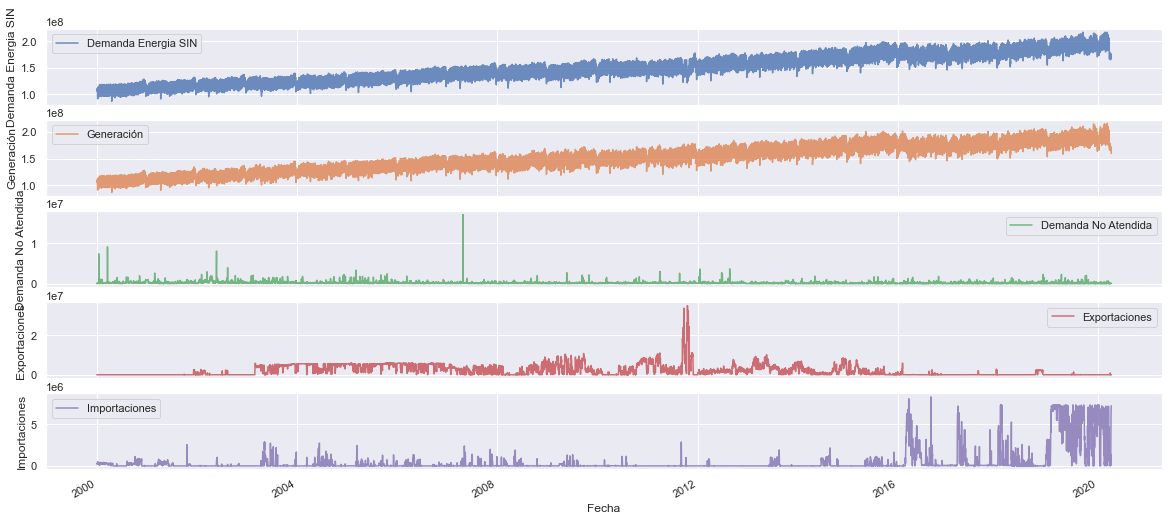

In [15]:
grafico_comportamiento_variables(dataset)

### Comportamiento variables por mes

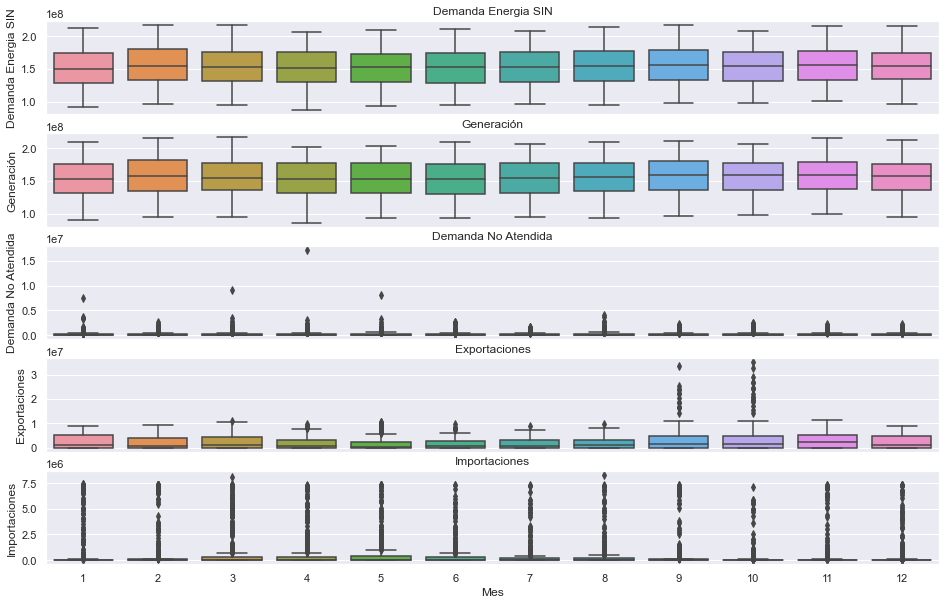

In [16]:
grafico_comportamiento_variables_por_mes(dataset)

In [17]:
'Fecha Mínima {} - Fecha Máxima {}'.format(dataset.index.min(),dataset.index.max())

'Fecha Mínima 2000-01-03 00:00:00 - Fecha Máxima 2020-04-05 00:00:00'

### Datos estación filtrado por Variable y Fecha

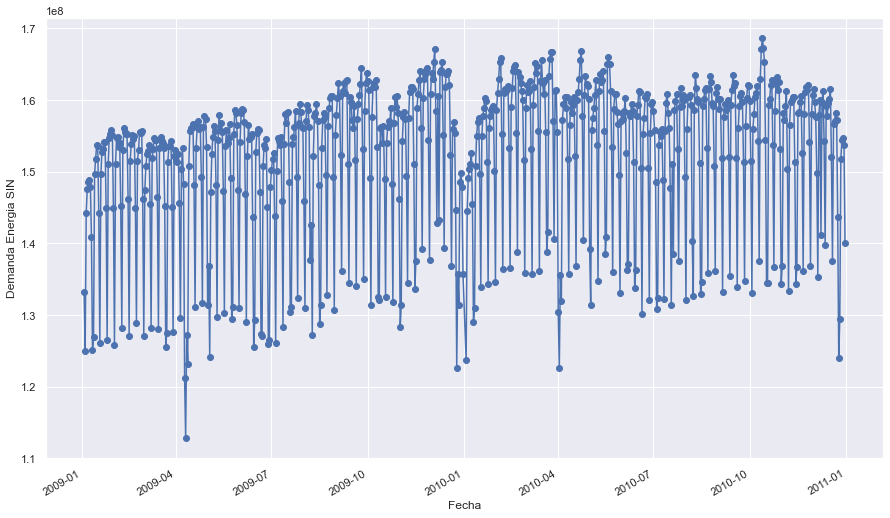

In [18]:
grafico_filtrado_fecha_variable(datos=dataset,fecha_min='2009-01',fecha_max='2010-12',variable='Demanda Energia SIN')

### Remuestreo de los datos filtrado por Variable y Fecha

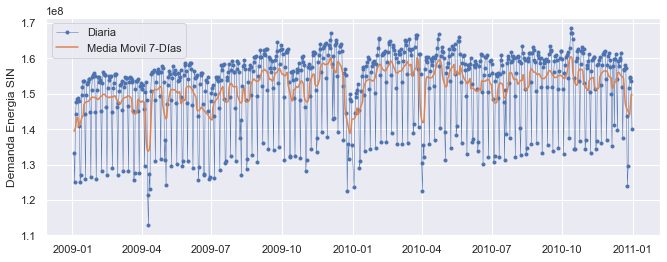

In [19]:
grafico_resampling_rolling_window(datos=dataset,fecha_min='2009-01',fecha_max='2010-12',variable='Demanda Energia SIN')